In [1]:
import silq
silq.initialize("EWJN")

qc.show_subprocess_widget()
%matplotlib nbagg

Initializing imports


<IPython.core.display.Javascript object>

Initializing functions
Initializing instruments
Initializing layout
Initializing data
Initializing analysis
Initializing parameters
Initializing plotting
Initialization complete


# Single measurements

In [27]:
# Determine empty, load, read fidelities
ELR_parameter.setup(samples=400, print=True)
%time results = ELR_parameter()

fidelity_empty: 0.890
fidelity_load: 1.000
fidelity_read: 0.626
up_proportion: 0.598
dark_counts: 0.193
contrast: 0.405
Wall time: 46.7 s


In [ ]:
T1_parameter.setup(samples=1000)
T1_parameter(5)
%time up_proportion, = T1_parameter()
print('Up proportion: {:.2f}'.format(up_proportion))

T1_parameter.setup(samples=200)
T1_parameter(3000)
%time up_proportion, = T1_parameter()
print('Up proportion: {:.2f}'.format(up_proportion))


DF(0)
DS(0)
LB(0)
RB(0)
SRC(0)
TG(0)
TGAC(0)


DF(2.57)
DS(2.57)
LB(3.8)
RB(3.8)
SRC(0.25)
TG(15.564)
TGAC(1.842)


# DC sweep

### Turnon

In [403]:
for k in np.linspace(1.5,0,6):
    turnon_param(k)

In [4]:
turnon_vals = list(np.linspace(0, 1.6, 200))

In [ ]:
DC_parameter.setup()
# data = qc.Loop(turnon_param[turnon_vals]
data = qc.Loop(dummy_param[0:1000:1], delay=1
               ).each(DC_parameter
                      ).then(qc.Task(layout.stop)
                             ).run(name='turnon',
                                   progress_interval=True)
plot = qc.MatPlot(data.DC_voltage)

### Pinchoff

In [6]:
turnon_voltage = 1.9
pinchoff_vals = list(np.linspace(turnon_voltage, 0, 200))
gate = RB

turnon_param(turnon_voltage)
DC_parameter.setup()
data = qc.Loop(gate[pinchoff_vals]
               ).each(DC_parameter
                      ).then(qc.Task(layout.stop)
                             ).run(name='Pinchoff_{}'.format(gate.name),
                                   progress_interval=True)
plot = qc.MatPlot(data.DC_voltage)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-10-12/#013_Pinchoff_RB_15-51-46'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Setpoint | RB_set     | RB           | (200,)
   Measured | DC_voltage | DC_voltage   | (200,)
started at 2016-10-12 15:51:47


### 1D DC scan

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-11-03/#003_DC_TGAC_scan_11-50-05'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Setpoint | TGAC_set   | TGAC         | (50,)
   Measured | DC_voltage | DC_voltage   | (50,)
started at 2016-11-03 11:50:08


<IPython.core.display.Javascript object>


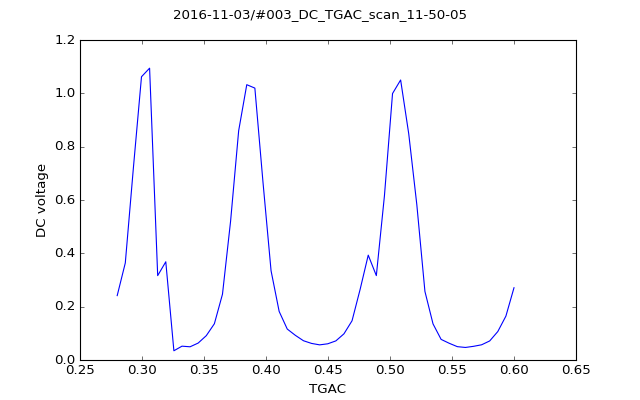

In [2]:
gate1 = TGAC

gate1_vals = list(np.linspace(0.28,0.6, 50))

DC_parameter.setup()
data = qc.Loop(gate1[gate1_vals]
              ).each(DC_parameter
                    ).then(qc.Task(layout.stop)
                          ).run(name='DC_{}_scan'.format(gate1.name),
                                progress_interval=True)

plot = qc.MatPlot(data.DC_voltage)

### 2D DC scans

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-11-03/#008_DC_TGAC_vs_DF_DS_scan_12-07-43'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Setpoint | TGAC_set   | TGAC         | (40,)
   Setpoint | DF_DS_set  | DF_DS        | (40, 60)
   Measured | DC_voltage | DC_voltage   | (40, 60)
started at 2016-11-03 12:07:46


<IPython.core.display.Javascript object>


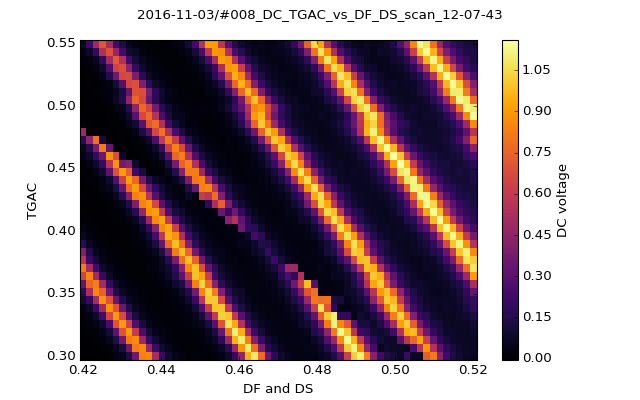

In [7]:
gate1 = TGAC
gate2 = DF_DS

gate1_vals = list(np.linspace(0.3,0.55, 40))
gate2_vals = list(np.linspace(0.42, 0.52, 60))

DC_parameter.setup()
data = qc.Loop(gate1[gate1_vals]
              ).loop(gate2[gate2_vals]
                    ).each(DC_parameter
                          ).then(qc.Task(layout.stop)
                                ).run(name='DC_{}_vs_{}_scan'.format(gate1.name, gate2.name),
                                      progress_interval=True)

plot = qc.MatPlot(data.DC_voltage)

# ELR sequence

In [8]:
ELR_parameter.pulse_sequence['read'].duration = 80
ELR_parameter.setup(samples=100, t_read=20)
result = ELR_parameter()

In [11]:
TGAC_vals = list(np.linspace(0.337,0.343,12))
DF_DS_vals = list(np.linspace(0.4815, 0.484,10))

In [12]:
ELR_parameter.pulse_sequence['read'].duration = 100
ELR_parameter.setup(samples=200, t_read=20)
data = qc.Loop(TGAC[TGAC_vals]
              ).loop(DF_DS[DF_DS_vals]
                    ).each(ELR_parameter
                          ).run(name='ELR_calibration',
                                progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-11-09/#006_ELR_calibration_17-38-01'
   <Type>   | <array_id>     | <array.name>   | <array.shape>
   Setpoint | TGAC_set       | TGAC           | (12,)
   Setpoint | DF_DS_set      | DF_DS          | (12, 10)
   Measured | fidelity_empty | fidelity_empty | (12, 10)
   Measured | fidelity_load  | fidelity_load  | (12, 10)
   Measured | fidelity_read  | fidelity_read  | (12, 10)
   Measured | up_proportion  | up_proportion  | (12, 10)
   Measured | dark_counts    | dark_counts    | (12, 10)
   Measured | contrast       | contrast       | (12, 10)
started at 2016-11-09 17:38:05


<IPython.core.display.Javascript object>


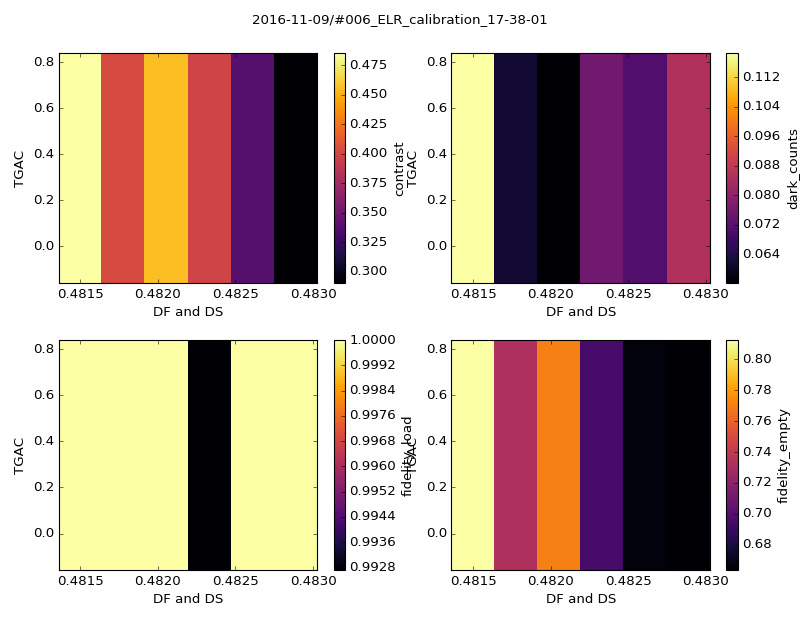

In [13]:
plot = qc.MatPlot(subplots=(2,2), figsize=(10,8), interval=10)
plot.add(data.contrast, subplot=1, nticks=6)
plot.add(data.dark_counts, subplot=2, nticks=6)
plot.add(data.fidelity_load, subplot=3, nticks=6)
plot.add(data.fidelity_empty, subplot=4, nticks=6)
plot.fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plotQ = qc.QtPlot()
plotQ.add(data.contrast)
plotQ = qc.QtPlot()
plotQ.add(data.dark_counts)
plotQ = qc.QtPlot()
plotQ.add(data.fidelity_load)
plotQ = qc.QtPlot()
plotQ.add(data.fidelity_empty)

In [4]:
TGAC(0.34)
DF_DS(0.4825)

In [9]:
ELR_parameter.setup(samples=100, print=True)
ELR_parameter();

fidelity_empty: 0.643
fidelity_load: 1.000
fidelity_read: 0.829
up_proportion: 0.330
dark_counts: 0.144
contrast: 0.186


In [8]:
layout.start()

# Adiabatic sweep scan

### center frequency scan

This code sweeps over the adiabatic sweep center frequency to find the ESR frequency.

In [3]:
interfaces['arbstudio'].final_delay(10)

adiabatic_sweep_parameter.pulse_sequence['adiabatic_sweep'].frequency_deviation=.7e6
adiabatic_sweep_parameter.pulse_sequence['adiabatic_sweep'].duration = 0.5

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-11-10/#008_adiabatic_sweep_12-09-46'
   <Type>   | <array_id>          | <array.name>    | <array.shape>
   Setpoint | adiabatic_sweep_set | adiabatic_sweep | (67,)
   Measured | fidelity_load       | fidelity_load   | (67,)
   Measured | fidelity_read       | fidelity_read   | (67,)
   Measured | up_proportion       | up_proportion   | (67,)
   Measured | dark_counts         | dark_counts     | (67,)
   Measured | contrast            | contrast        | (67,)
started at 2016-11-10 12:09:49


<IPython.core.display.Javascript object>


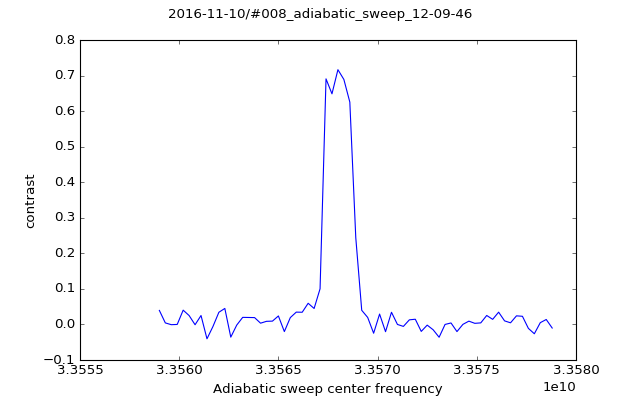

In [4]:
f_center = 33.569e9
f_span = 20e6
f_step = .3e6
adiabatic_sweep_vals = list(np.arange(f_center-f_span/2, f_center+f_span/2, f_step))

adiabatic_sweep_parameter.setup(samples=200)
data = qc.Loop(adiabatic_sweep_parameter[adiabatic_sweep_vals]
                     ).each(adiabatic_sweep_parameter
                           ).run(name='adiabatic_sweep',
                                progress_interval=True)
plot = qc.MatPlot(data.contrast, use_offset=False)

### LR calibration scan

In [4]:
frequency_center = 33.568e9

In [5]:
TGAC_vals = list(np.linspace(0.337,0.343,10))
DF_DS_vals = list(np.linspace(0.481, 0.485,12))

In [6]:
adiabatic_sweep_parameter.pulse_sequence['read'].duration = 80
adiabatic_sweep_parameter.setup(samples=200)
adiabatic_sweep_parameter(frequency_center)
data = qc.Loop(TGAC[TGAC_vals]
              ).loop(DF_DS[DF_DS_vals]
                    ).each(adiabatic_sweep_parameter
                          ).run(name='adiabatic_calibration',
                                progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-11-11/#005_adiabatic_calibration_10-05-30'
   <Type>   | <array_id>    | <array.name>  | <array.shape>
   Setpoint | TGAC_set      | TGAC          | (10,)
   Setpoint | DF_DS_set     | DF_DS         | (10, 12)
   Measured | fidelity_load | fidelity_load | (10, 12)
   Measured | fidelity_read | fidelity_read | (10, 12)
   Measured | up_proportion | up_proportion | (10, 12)
   Measured | dark_counts   | dark_counts   | (10, 12)
   Measured | contrast      | contrast      | (10, 12)
started at 2016-11-11 10:05:34


<IPython.core.display.Javascript object>


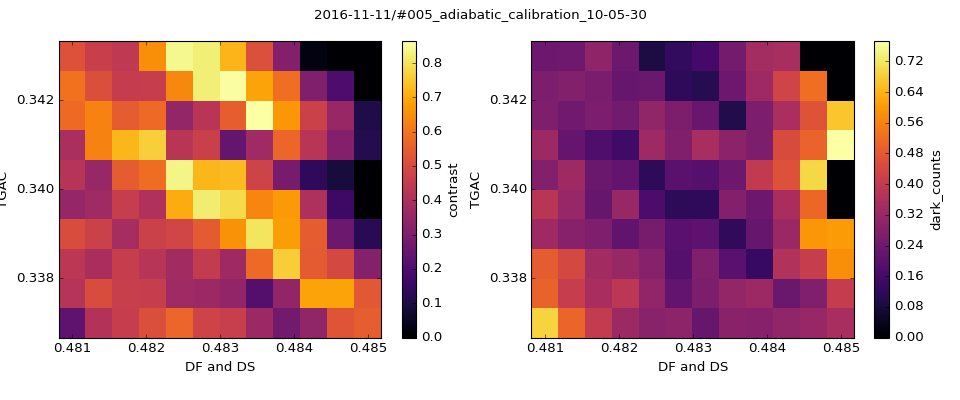

In [7]:
plot = qc.MatPlot(subplots=(1,2), figsize=(12,5), interval=10)
plot.add(data.contrast, subplot=1, nticks=6)
plot.add(data.dark_counts, subplot=2, nticks=6)
plot.fig.tight_layout(rect=[0, 0.03, 1, 0.95])

### frequency span versus time scan

In [5]:
pulse = adiabatic_sweep_parameter.pulse_sequence['adiabatic_sweep']
adiabatic_deviation_parameter = general_parameters.AttributeParameter(object=pulse, attribute='frequency_deviation')
adiabatic_duration_parameter = general_parameters.AttributeParameter(object=pulse, attribute='duration')

adiabatic_deviation_vals = list(np.logspace(5.5, 7.8, 8))
adiabatic_duration_vals = list(np.logspace(-2.7, -0.3, 8))

In [18]:
adiabatic_sweep_parameter.pulse_sequence['read'].duration = 100
adiabatic_sweep_parameter.setup(samples=400)
adiabatic_sweep_parameter(frequency_center)
data = qc.Loop(adiabatic_deviation_parameter[adiabatic_deviation_vals]
              ).loop(adiabatic_duration_parameter[adiabatic_duration_vals]
                    ).each(adiabatic_sweep_parameter
                          ).run(name='adiabatic_deviation_vs_duration',
                                progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-11-11/#004_adiabatic_deviation_vs_duration_09-57-31'
   <Type>   | <array_id>              | <array.name>        | <array.shape>
   Setpoint | frequency_deviation_set | frequency_deviation | (10,)
   Setpoint | duration_set            | duration            | (10, 8)
   Measured | fidelity_load           | fidelity_load       | (10, 8)
   Measured | fidelity_read           | fidelity_read       | (10, 8)
   Measured | up_proportion           | up_proportion       | (10, 8)
   Measured | dark_counts             | dark_counts         | (10, 8)
   Measured | contrast                | contrast            | (10, 8)
started at 2016-11-11 09:57:34


<IPython.core.display.Javascript object>


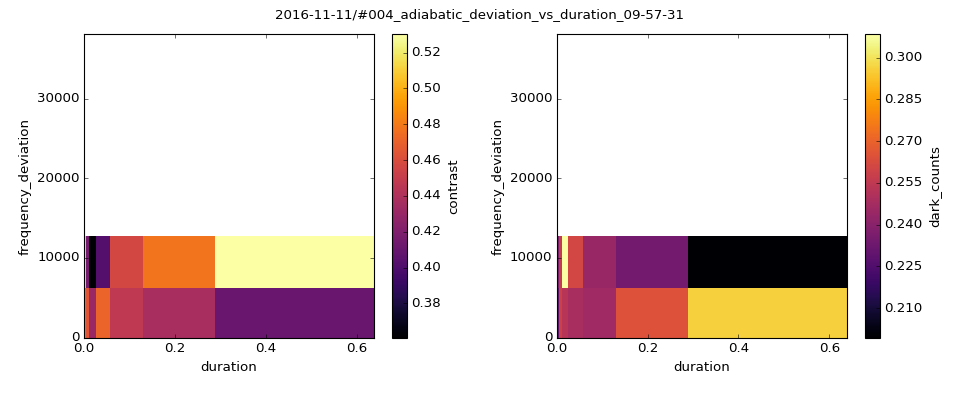

In [21]:
plot = qc.MatPlot(subplots=(1,2), figsize=(12,5), interval=10)
plot.add(data.contrast, subplot=1, nticks=6)
plot.add(data.dark_counts, subplot=2, nticks=6)
# for ax in plot.subplots:
#     ax.set_xscale('log')
#     ax.set_yscale('log')
plot.fig.tight_layout(rect=[0, 0.03, 1, 0.95])

### Single adiabatic measurement

In [19]:
adiabatic_sweep_parameter(33.585e9)
adiabatic_sweep_parameter.setup(samples=400, print=True)
adiabatic_sweep_parameter()

fidelity_load: 0.000
fidelity_read: 0.718
up_proportion: 0.868
dark_counts: 0.135
contrast: 0.733


(0,
 0.71754328621908126,
 0.86769230769230765,
 0.13506493506493505,
 0.73262737262737265)

# Read level sweep

In [28]:
variable_read_parameter.setup(samples=100)
data = qc.Loop(variable_read_parameter[-1.5:2.5:0.04]
                     ).each(variable_read_parameter
                           ).run(name='variable_read',
                                progress_interval=True)

NameError: name 'variable_read_parameter' is not defined

In [42]:
plotQ = qc.QtPlot()
plotQ.add(data.Channel_A_signal)

plotQ = qc.QtPlot()
plotQ.add(data.Channel_C_signal)

# T1 measurement

In [11]:
# Prepare measurements: Determine threshold voltage
ELR_parameter.setup(samples=30)
ELR_parameter()
traces_read = ELR_parameter.trace_segments['output']['read']
_, _, threshold_voltage = analysis.find_high_low(traces_read)
assert threshold_voltage is not None, "Couldn't find accurate threshold"
print('Threshold voltage found at {:.2f} V'.format(threshold_voltage))

Threshold voltage found at 0.22 V


In [12]:
# Calculate T1 durations (shuffled)
T1_wait_times = list(np.logspace(1,4.2,num=20,base=10))
np.random.shuffle(T1_wait_times)
print('Shuffled T1 wait times: {}'.format(T1_wait_times))

Shuffled T1 wait times: [15848.931924611141, 1546.9407652462003, 3359.8182862837812, 69.519279617756055, 21.719114020174249, 10.0, 32.008340465997662, 102.45338593872233, 7297.2276446863925, 47.171991382132958, 4951.500669473131, 222.51967709560262, 1049.6696290308787, 327.93628590208834, 483.29302385717523, 10754.220761125622, 2279.789435643565, 712.24855848599145, 14.737406155824797, 150.98971606184202]


In [4]:
# Single point T1 sweep
T1_parameter.setup(threshold_voltage=threshold_voltage, samples=30, data_manager=data_manager_raw)
T1_parameter(30000)
data = qc.Loop(dummy_param[0:30:1]
              ).each(T1_parameter
                    ).run(name='T1_data_high', progress_interval=True)

# plotQ = qc.QtPlot()
# plotQ.add(data.up_proportion)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-09-21/#001_T1_data_high_08-47-35'
   <Type>   | <array_id>        | <array.name>      | <array.shape>
   Setpoint | dummy_set         | dummy             | (30,)
   Measured | up_proportion     | up_proportion     | (30,)
   Measured | num_traces_loaded | num_traces_loaded | (30,)
started at 2016-09-21 08:47:37


DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-09-20/#039_T1_single_sweep_16-46-59'
   <Type>   | <array_id>        | <array.name>      | <array.shape>
   Setpoint | T1_wait_time_set  | T1_wait_time      | (20,)
   Measured | up_proportion     | up_proportion     | (20,)
   Measured | num_traces_loaded | num_traces_loaded | (20,)
started at 2016-09-20 16:47:00


<IPython.core.display.Javascript object>


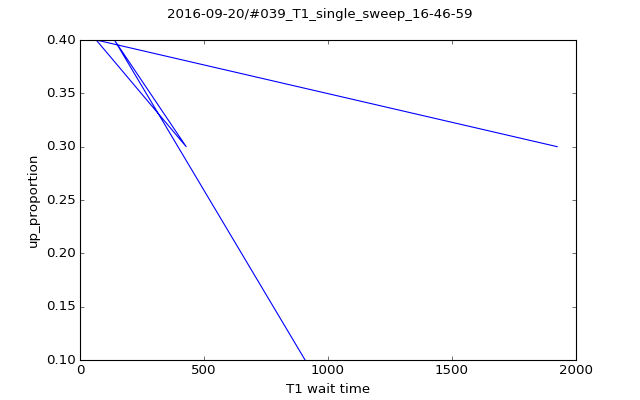

In [73]:
# Single T1 sweep
T1_parameter.setup(threshold_voltage=threshold_voltage, samples=10)

data = qc.Loop(T1_parameter[T1_wait_times]
                     ).each(T1_parameter
                           ).run(name='T1_single_sweep')

plotQ = qc.MatPlot()
plotQ.add(data.up_proportion)

In [15]:
# Continuous T1 sweep
setup_ELRLR = partial(ELRLR_parameter.setup, samples=400, data_manager=data_manager_raw)
setup_T1 = partial(T1_parameter.setup, threshold_voltage=threshold_voltage, samples=150, data_manager=data_manager_raw)
setup_ELRLR()
setup_T1()
data = qc.Loop(dummy_param[0:30:1]
              ).each(qc.Task(setup_ELRLR),
                     ELRLR_parameter,
                     qc.Task(setup_T1),
                     qc.Loop(T1_parameter[T1_wait_times]).each(T1_parameter)
                    ).run(name='T1_data', progress_interval=True)

# plotQ = qc.QtPlot()
# plotQ.add(data.up_proportion)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-10-21/#009_T1_data_17-09-21'
   <Type>   | <array_id>          | <array.name>      | <array.shape>
   Setpoint | dummy_set           | dummy             | (30,)
   Measured | fidelity_empty      | fidelity_empty    | (30,)
   Measured | fidelity_load       | fidelity_load     | (30,)
   Measured | fidelity_read       | fidelity_read     | (30,)
   Measured | up_proportion_1_3   | up_proportion     | (30,)
   Measured | dark_counts         | dark_counts       | (30,)
   Measured | contrast            | contrast          | (30,)
   Setpoint | T1_wait_time_set    | T1_wait_time      | (30, 20)
   Measured | up_proportion_3_0_0 | up_proportion     | (30, 20)
   Measured | num_traces_loaded   | num_traces_loaded | (30, 20)
started at 2016-10-21 17:09:23


In [19]:
data.sync()
print(data.T1_wait_time_set[0])
data.up_proportion_3_0_0[29]

[  1.58489000e+04   2.22520000e+02   1.07542000e+04   3.20083000e+01
   1.02453000e+02   3.27936000e+02   7.12249000e+02   1.04967000e+03
   4.95150000e+03   7.29723000e+03   1.54694000e+03   1.50990000e+02
   4.71720000e+01   2.17191000e+01   2.27979000e+03   3.35982000e+03
   4.83293000e+02   1.47374000e+01   1.00000000e+01   6.95193000e+01]


array([ 0.14094 ,  0.42    ,  0.193333,  0.510067,  0.463087,  0.436242,
        0.422819,  0.42953 ,  0.194631,  0.213333,  0.342282,  0.433333,
        0.44    ,  0.418919,  0.328859,  0.263514,  0.456376,  0.483221,
        0.436242,  0.44898 ])